# Setup

In [15]:
from llmstudio import LLM

In [16]:
claude2 = LLM("anthropic/claude-2.1")
gpt4 = LLM("openai/gpt-4-1106-preview")
gpt3 = LLM("openai/gpt-3.5-turbo")
llama2 = LLM("ollama/llama2")

# Chat
(sync/async methods available for all vendors)

### Non-streaming

In [17]:
gpt3.chat("What's your name")

{'id': '92817082-3ff8-43af-8c31-c271fb08f587',
 'chat_input': "What's your name",
 'chat_output': "I am an AI language model developed by OpenAI, and I don't have a personal name. However, you can refer to me as GPT-3 or ChatGPT. How can I assist you today?",
 'timestamp': 1707226149.9636118,
 'provider': 'openai',
 'model': 'gpt-3.5-turbo',
 'metrics': {'input_tokens': 4,
  'output_tokens': 44,
  'total_tokens': 48,
  'cost': 9.4e-05,
  'latency': 1.827862024307251,
  'time_to_first_token': 1.1629717350006104,
  'inter_token_latency': 0.01508363810452548,
  'tokens_per_second': 24.618926046704612},
 'parameters': {'temperature': 1,
  'max_tokens': 256,
  'top_p': 1,
  'frequency_penalty': 0,
  'presence_penalty': 0}}

### Streaming

In [18]:
response = gpt3.chat("Write a paragfraph about space", is_stream=True)
for chunk in response:
    print(chunk, end="", flush=True)

Space, a vast and infinite expanse, has always captured the curiosity and imagination of humanity. It is the realm beyond the Earth's atmosphere, beyond the confines of our planet, and holds countless mysteries waiting to be explored. From the shining stars that adorn the night sky to the distant galaxies that stretch across the cosmos, space is a place of wonder and awe. It harbors celestial bodies such as planets, moons, and asteroids, each with their unique characteristics and potential. The study of space, known as astronomy, has allowed us to gain insights into the formation of the universe, the existence of black holes, and even the possibility of extraterrestrial life. As humans continue to push the boundaries of exploration, the vastness of space offers a glimpse into the unknown, reminding us of the boundless possibilities that lie beyond our planet.

# Custom metrics

### You can include a callback to add custom metrics to your calls 
```python
def calculate_custom_metrics(
    self,
    input: str,
    output: str,
):
    hello_counter = output.lower().count("hello")
    return {"hello_counter": hello_counter}
```

### In this example, we will be counting the amount of "Hello"s the model will say.

In [19]:
response = llama2.chat("Say hello 10 times")

In [20]:
print("Response:")
print(response.get('chat_output'))

Response:
Of course! Here are 10 greetings:

1. Hello!
2. Hi there!
3. Hey!
4. Howdy!
5. Hola!
6. Bonjour!
7. G'day!
8. Kia ora!
9. Salut!
10. 你好 (nǐ hǎo)


In [21]:
print("# Hellos:")
print(response.get('metrics').get('hello_counter'))

# Hellos:
1


# Compare

#### With LLMstudio, you can compare the performance of multiple models at the same time.

#### You can do this concurrently, while testing against multiple tasks.

In [22]:
task1 = """
Task: What is the insurance final value to be refunded? Think step by step, and your only response should only be the refunded value in the following format 'Refund:$x', where x is the ammount to be refunded.

Q: I purchased my ticket for $200 but I was charged an extra 15% due to some insurance. Out of those 15%, 80% was insurance against baggage lost which I do want to keep. I want a refund on the insurance part that I do not want.

A: Let's think step by step
""" 

In [23]:
tasks = [task1]
expected_outputs = ["Refund:$6"]

In [24]:
# List of LLM objects
llms = [claude2, gpt4, gpt3, llama2]

In [25]:
import asyncio
from sentence_transformers import SentenceTransformer, util

# Function to calculate similarity
def calculate_similarity(model_output, expected_output):
    model = SentenceTransformer("paraphrase-MiniLM-L6-v2")
    embedding1 = model.encode(model_output, convert_to_tensor=True)
    embedding2 = model.encode(expected_output, convert_to_tensor=True)
    cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)
    return cosine_scores.item()

# Function to run a single task against all models and calculate metrics
async def run_task(task, expected_output, llms):
    # Run all models concurrently
    responses = await asyncio.gather(*(llm.async_chat(task) for llm in llms), return_exceptions=True)
    
    # Dictionary to hold metrics by model
    metrics_by_model = {}
    
    # Process responses and calculate metrics
    for llm, response in zip(llms, responses):
        # Store metrics for this model
        metrics_by_model[llm.model] = {
            'average_latency': response['metrics']['latency'],
            'average_cost': response['metrics']['cost'],
            'average_output_token': response['metrics']['output_tokens'],
            'average_similarity': calculate_similarity(response['chat_output'], expected_output),
            'average_time_to_first_token': response['metrics']['time_to_first_token'],
            'average_inter_token_latency': response['metrics']['inter_token_latency'],
            'average_tokens_per_second': response['metrics']['tokens_per_second']
        }
    
    return metrics_by_model

# Main function to run all tasks
async def run_all_tasks(tasks, expected_outputs, llms):
    all_metrics_by_model = {}
    for task, expected_output in zip(tasks, expected_outputs):
        task_metrics_by_model = await run_task(task, expected_output, llms)
        for model, metrics in task_metrics_by_model.items():
            # Aggregate metrics for each model
            if model not in all_metrics_by_model:
                all_metrics_by_model[model] = metrics
            else:
                for key, value in metrics.items():
                    all_metrics_by_model[model][key] += value
    
    # Divide each metric by the number of tasks to get the average
    for _, metrics in all_metrics_by_model.items():
        for key in metrics:
            metrics[key] /= len(tasks)
    
    return all_metrics_by_model

# Run the main function and get metrics by model
all_metrics_by_model = await run_all_tasks(tasks, expected_outputs, llms)

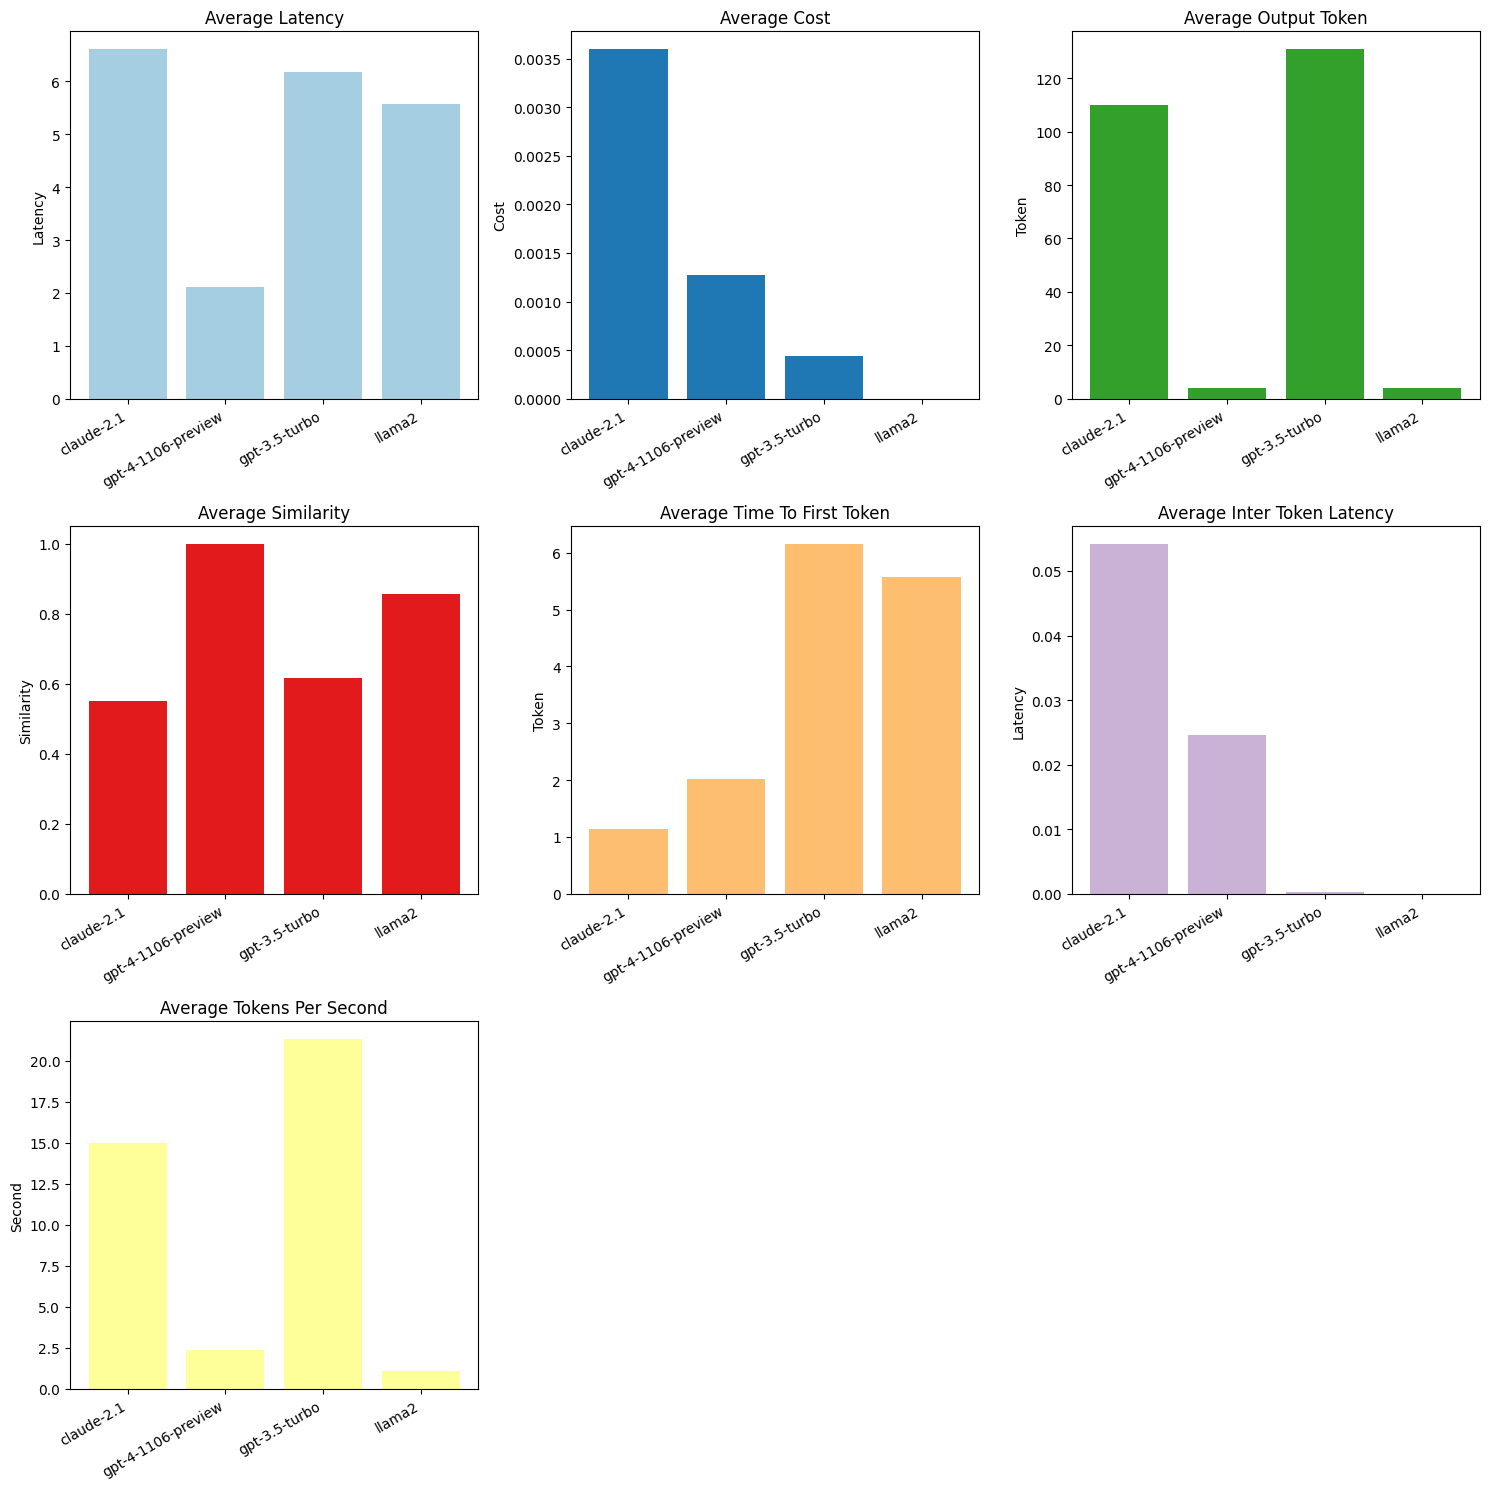

In [26]:
import matplotlib.pyplot as plt

def create_metric_plots(output_dict):
    # Extract metrics and model names
    models = list(output_dict.keys())
    metrics = list(output_dict[models[0]].keys())  # Assuming all models have the same metrics

    # Determine grid size
    num_metrics = len(metrics)
    grid_size = int(num_metrics ** 0.5)
    if grid_size * grid_size < num_metrics:
        grid_size += 1

    # Create subplots
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axs = axs.flatten()  # Flatten the 2D array of axes for easy iteration

    # Plot each metric
    for i, metric in enumerate(metrics):
        values = [output_dict[model][metric] for model in models]
        axs[i].bar(models, values, color=plt.cm.Paired(i / len(metrics)))
        axs[i].set_title(metric.replace('_', ' ').title())
        axs[i].set_ylabel(metric.split('_')[-1].title())
        axs[i].set_xticks(range(len(models))) 
        axs[i].set_xticklabels(models, rotation=30, ha='right')

    # Hide any unused subplots
    for i in range(num_metrics, len(axs)):
        axs[i].axis('off')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Display the plots
    plt.show()

create_metric_plots(all_metrics_by_model)